<a href="https://colab.research.google.com/github/walidbayoud/Stock_Price_Prediction_LSTM/blob/main/Stock_Price_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description:
This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation (MSFT) using the past days' stock price.


# Stock Price Prediction with LSTM – Research-Oriented Version

**Research question:**  
Do LSTM-based models provide a statistically meaningful improvement over simple time-series baselines for short-term stock price prediction?

**Main elements in this notebook:**
- Clear train / validation / test split on a time axis  
- LSTM model for regression  
- Naive time-series baseline for comparison  
- Proper error metrics (RMSE, MAE, MAPE, directional accuracy)  
- Plots that compare predictions vs. actual prices


### Importring Data

In [65]:
#Import the libraries
import pandas as pd

#Get Data from the csv file
df = pd.read_csv('data/MSFT.csv')
#Display Data
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...,...
9598,2024-04-15,426.600006,426.820007,413.429993,413.640015,413.640015,20273500
9599,2024-04-16,414.570007,418.399994,413.730011,414.579987,414.579987,16765600
9600,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,15855500
9601,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,21029900


## Processing Data

In [66]:
#Limit the columns to only Date and Close
df = df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9598,2024-04-15,413.640015
9599,2024-04-16,414.579987
9600,2024-04-17,411.839996
9601,2024-04-18,404.269989


In [67]:
#Turn the Date strings to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

/var/folders/fw/35zr31d95yb51prj11ykzxbh0000gn/T/ipykernel_90232/4145630550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9598   2024-04-15
9599   2024-04-16
9600   2024-04-17
9601   2024-04-18
9602   2024-04-19
Name: Date, Length: 9603, dtype: datetime64[ns]

In [68]:
#Deleting the actula indexe and replace it by Date
df.index=df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-04-15,413.640015
2024-04-16,414.579987
2024-04-17,411.839996


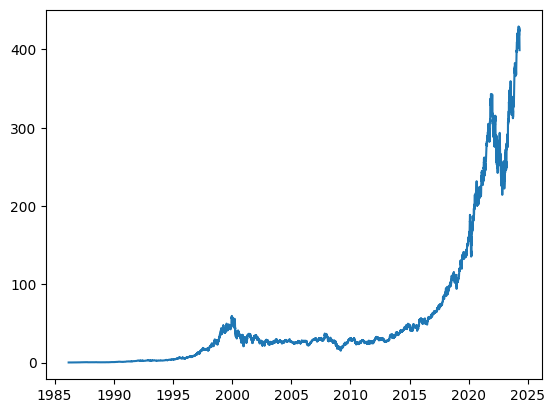

In [69]:
#visualizing the processed Data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.plot(df.index, df['Close'])

In [70]:
#Getting the Data ready to Train
import pandas as pd
import numpy as np


def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_date = target_date + pd.Timedelta(days=1)  # Change to daily intervals

        if next_date > last_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    for i in range(n):
        ret_df[f'Target-{n - i}'] = [x[i] for x in X]

    ret_df['Target'] = Y

    return ret_df

# Test the function
windowed_df = df_to_windowed_df(df, '2022-11-01', '2023-11-01', n=3)
print(windowed_df)



    Target Date    Target-3    Target-2    Target-1      Target
0    2022-11-01  226.750000  235.869995  232.130005  228.169998
1    2022-11-02  235.869995  232.130005  228.169998  220.100006
2    2022-11-03  232.130005  228.169998  220.100006  214.250000
3    2022-11-04  228.169998  220.100006  214.250000  221.389999
4    2022-11-05  228.169998  220.100006  214.250000  221.389999
..          ...         ...         ...         ...         ...
361  2023-10-28  330.529999  340.670013  327.890015  329.809998
362  2023-10-29  330.529999  340.670013  327.890015  329.809998
363  2023-10-30  340.670013  327.890015  329.809998  337.309998
364  2023-10-31  327.890015  329.809998  337.309998  338.109985
365  2023-11-01  329.809998  337.309998  338.109985  346.070007

[366 rows x 5 columns]


In [71]:
#Reshape the Data

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np= windowed_dataframe.to_numpy()

  dates =df_as_np[:,0]

  middle_matrix = df_as_np[:,1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y= df_as_np[:,-1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y=windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((366,), (366, 3, 1), (366,))

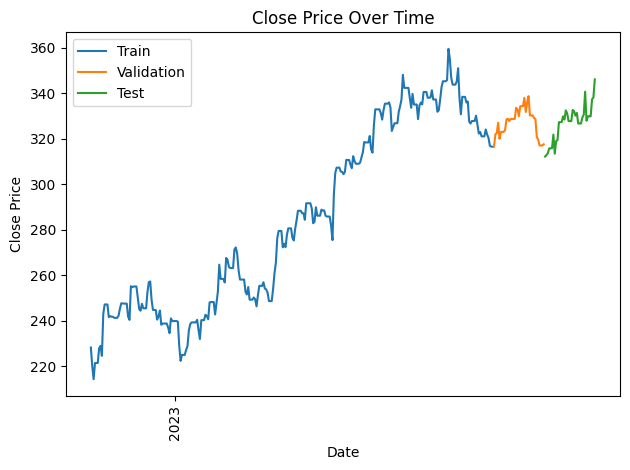

In [72]:
#Split the Data into training,validation, and testing Data

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year-month format
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show tick for every year

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')

plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()


In [73]:
#Creating the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32,activation='relu'),
                    layers.Dense(32,activation='relu'),
                    layers.Dense(1)])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 79715.5000 - mean_absolute_error: 279.5119 - val_loss: 106469.4609 - val_mean_absolute_error: 326.2382
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 81672.4922 - mean_absolute_error: 282.9177 - val_loss: 105978.8125 - val_mean_absolute_error: 325.4853
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80771.7500 - mean_absolute_error: 281.4557 - val_loss: 105264.1406 - val_mean_absolute_error: 324.3856
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80920.8594 - mean_absolute_error: 281.6774 - val_loss: 103926.6562 - val_mean_absolute_error: 322.3175
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79526.9688 - mean_absolute_error: 279.1495 - val_loss: 102081.0234 - val_mean_absolute_error: 319.4414
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78075.1406 - mean_absolute_error: 276.6480 - val_loss: 99027.5078 - val_mean_absolute_error: 314.6256
Epoch 7/100
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


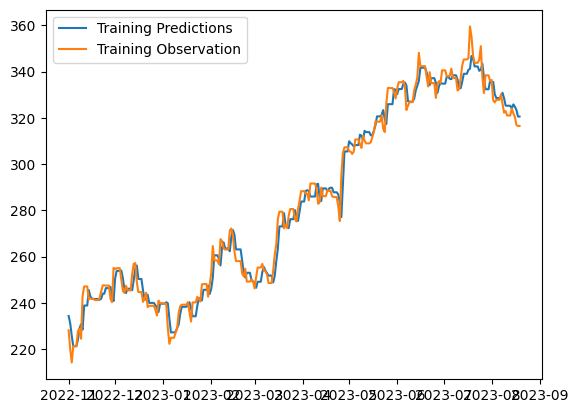

In [74]:
#training the Model
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observation'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


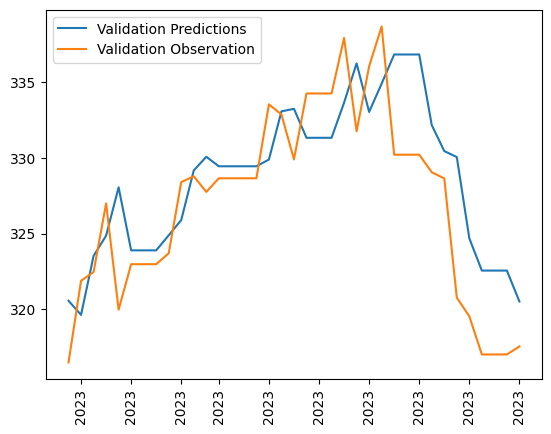

In [75]:
val_predictions = model.predict(X_val).flatten()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year-month format
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observation'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


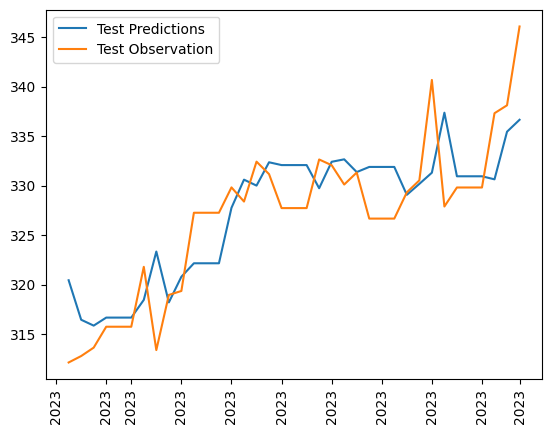

In [76]:
test_predictions = model.predict(X_test).flatten()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year-month format
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observation'])

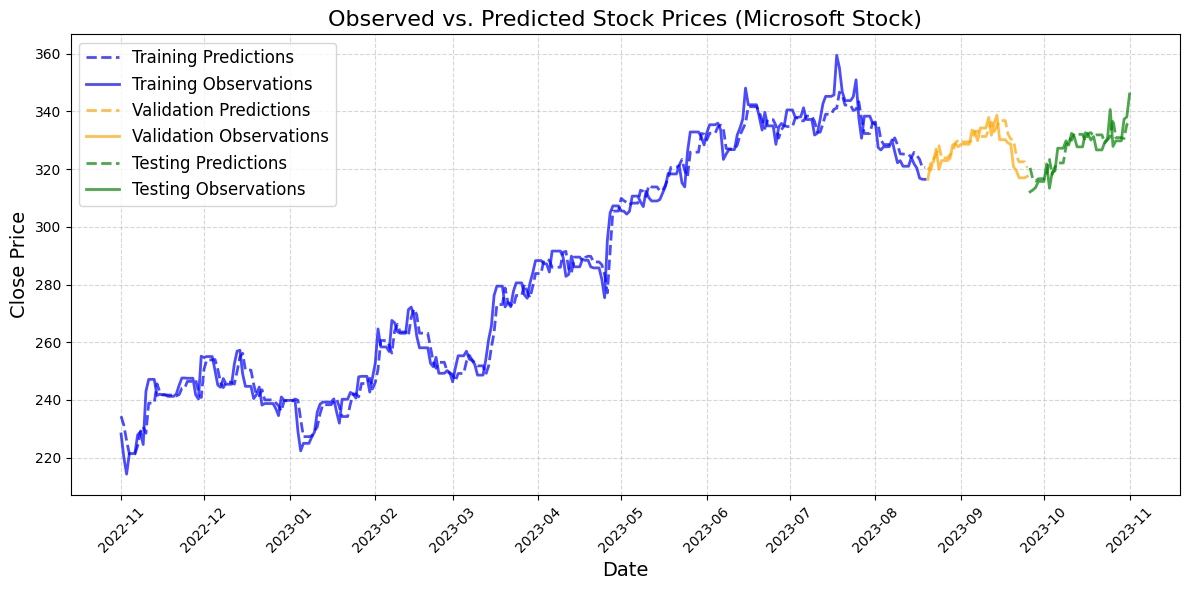

In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))


plt.plot(dates_train, train_predictions, linestyle='--', color='blue', linewidth=2, alpha=0.7)
plt.plot(dates_train, y_train, linestyle='-', color='blue', linewidth=2, alpha=0.7)

plt.plot(dates_val, val_predictions, linestyle='--', color='orange', linewidth=2, alpha=0.7)
plt.plot(dates_val, y_val, linestyle='-', color='orange', linewidth=2, alpha=0.7)

plt.plot(dates_test, test_predictions, linestyle='--', color='green', linewidth=2, alpha=0.7)
plt.plot(dates_test, y_test, linestyle='-', color='green', linewidth=2, alpha=0.7)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.title('Observed vs. Predicted Stock Prices (Microsoft Stock)', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

# Format dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend(['Training Predictions', 'Training Observations',
            'Validation Predictions', 'Validation Observations',
            'Testing Predictions', 'Testing Observations'],
           loc='upper left', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()


## Research-Oriented Evaluation: Metrics and Baseline

In this section we:
1. Define regression and direction metrics.
2. Evaluate the LSTM model on the test set.
3. Create a **naive baseline** that predicts "tomorrow = last observed price".
4. Compare the LSTM model against the baseline.


In [78]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    """Percentage of times the model gets the direction (up/down) correct."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)

    # sign > 0 ⇒ up, < 0 ⇒ down, = 0 ⇒ flat
    correct = np.sign(true_diff) == np.sign(pred_diff)
    return np.mean(correct) * 100

# Ensure we have test predictions
try:
    test_predictions
except NameError:
    test_predictions = model.predict(X_test).flatten()

lstm_rmse = rmse(y_test, test_predictions)
lstm_mae  = mae(y_test, test_predictions)
lstm_mape = mape(y_test, test_predictions)
lstm_dir  = directional_accuracy(y_test, test_predictions)

print("LSTM on test set")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE : {lstm_mae:.4f}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"Directional accuracy: {lstm_dir:.2f}%")


LSTM on test set
RMSE: 4.5692
MAE : 3.5611
MAPE: 1.09%
Directional accuracy: 55.56%


In [79]:
# Naive baseline: predict next price as the last observed price in the input window
# X_test has shape (n_samples, window_size, 1)
last_observed = X_test[:, -1, 0]  # last value in each window

baseline_rmse = rmse(y_test, last_observed)
baseline_mae  = mae(y_test, last_observed)
baseline_mape = mape(y_test, last_observed)
baseline_dir  = directional_accuracy(y_test, last_observed)

print("Naive baseline on test set")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE : {baseline_mae:.4f}")
print(f"MAPE: {baseline_mape:.2f}%")
print(f"Directional accuracy: {baseline_dir:.2f}%")


Naive baseline on test set
RMSE: 5.0179
MAE : 4.0089
MAPE: 1.22%
Directional accuracy: 63.89%


In [80]:
import pandas as pd

results_df = pd.DataFrame(
    {
        "Model": ["LSTM", "Naive baseline"],
        "RMSE": [lstm_rmse, baseline_rmse],
        "MAE": [lstm_mae, baseline_mae],
        "MAPE (%)": [lstm_mape, baseline_mape],
        "Directional accuracy (%)": [lstm_dir, baseline_dir],
    }
)

results_df


,Model,RMSE,MAE,MAPE (%),Directional accuracy (%)
0,LSTM,4.569154,3.561123,1.087885,55.555556
1,Naive baseline,5.017948,4.008917,1.223336,63.888889


## ARIMA Baseline Model

To make the comparison more solid, I also added a classical ARIMA time series model.
This gives a third point of reference next to the naive baseline and the LSTM.


In [81]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Build a simple univariate time series on the same target we used for the LSTM
ts = pd.Series(windowed_df['Target'].values, index=windowed_df['Target Date'])

# Use the same split indices as before
train_end = int(len(ts) * 0.9)  # train + validation
ts_train = ts.iloc[:train_end]
ts_test_part = ts.iloc[train_end:]

print(f"Train points for ARIMA: {len(ts_train)}, test points: {len(ts_test_part)}")

# Try a small set of ARIMA(p, d, q) orders and pick the one with lowest AIC
candidate_orders = [(1, 0, 0), (1, 1, 0), (2, 1, 0), (2, 1, 1), (5, 1, 0)]
best_aic = np.inf
best_order = None
best_model = None

for order in candidate_orders:
    try:
        model = sm.tsa.ARIMA(ts_train, order=order)
        res = model.fit()
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
            best_model = res
    except Exception as e:
        # Some combinations can fail to converge; I just skip them
        print(f"Skipping order {order} because of: {e}")
        continue

print(f"Best ARIMA order based on AIC: {best_order}, AIC = {best_aic:.2f}")

# Forecast the same number of steps as the length of y_test
steps = len(y_test)
arima_forecast = best_model.forecast(steps=steps)
arima_forecast = np.array(arima_forecast)

# Make sure the shapes are aligned
print("ARIMA forecast shape:", arima_forecast.shape, "y_test shape:", y_test.shape)


Train points for ARIMA: 329, test points: 37
Best ARIMA order based on AIC: (2, 1, 1), AIC = 1858.33
ARIMA forecast shape: (37,) y_test shape: (37,)


/Users/walidbayoud/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/walidbayoud/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/walidbayoud/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/walidbayoud/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/walidbayoud/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473

In [82]:
# Evaluate ARIMA model with the same metrics

arima_rmse = rmse(y_test, arima_forecast)
arima_mae  = mae(y_test, arima_forecast)
arima_mape = mape(y_test, arima_forecast)
arima_dir  = directional_accuracy(y_test, arima_forecast)

print("ARIMA on test set")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE : {arima_mae:.4f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"Directional accuracy: {arima_dir:.2f}%")


ARIMA on test set
RMSE: 11.9181
MAE : 10.3516
MAPE: 3.13%
Directional accuracy: 30.56%


In [83]:
# Update the comparison table to include ARIMA

results_df = pd.DataFrame(
    {
        "Model": ["LSTM", "Naive baseline", "ARIMA"],
        "RMSE": [lstm_rmse, baseline_rmse, arima_rmse],
        "MAE": [lstm_mae, baseline_mae, arima_mae],
        "MAPE (%)": [lstm_mape, baseline_mape, arima_mape],
        "Directional accuracy (%)": [lstm_dir, baseline_dir, arima_dir],
    }
)

results_df


,Model,RMSE,MAE,MAPE (%),Directional accuracy (%)
0,LSTM,4.569154,3.561123,1.087885,55.555556
1,Naive baseline,5.017948,4.008917,1.223336,63.888889
2,ARIMA,11.918085,10.351581,3.129043,30.555556


## Visual Comparison on the Test Set

Here I plot the true prices on the test period together with the three models:
- LSTM
- Naive baseline (last observed value)
- ARIMA


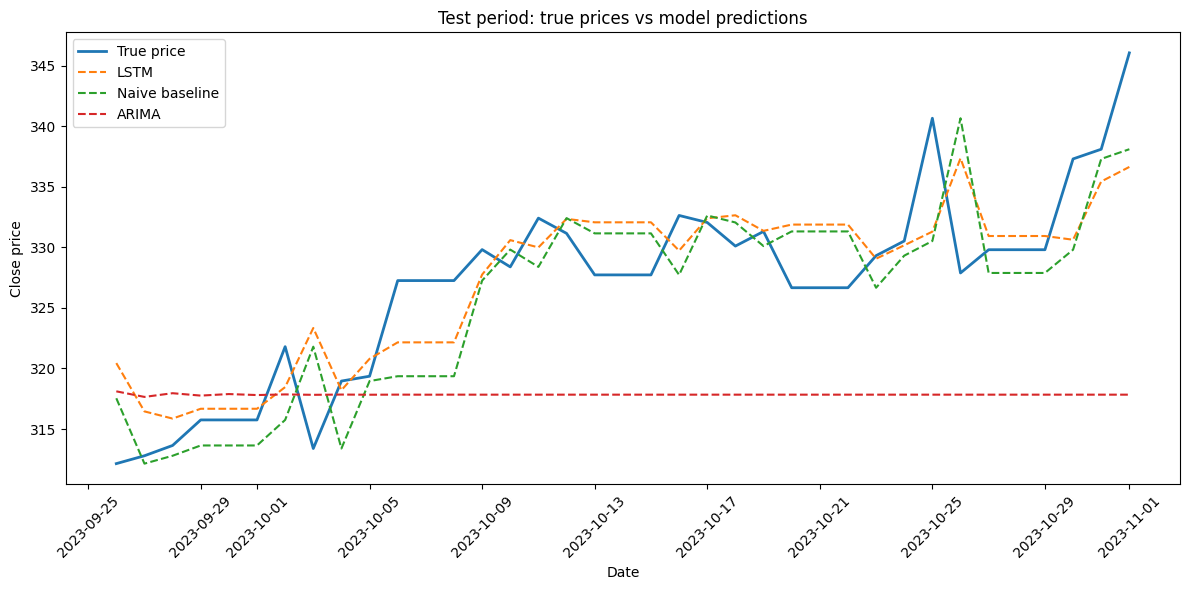

In [84]:
plt.figure(figsize=(12, 6))

# True prices
plt.plot(dates_test, y_test, label='True price', linewidth=2)

# LSTM predictions
plt.plot(dates_test, test_predictions, linestyle='--', label='LSTM')

# Naive baseline (last observed in the window)
plt.plot(dates_test, last_observed, linestyle='--', label='Naive baseline')

# ARIMA predictions
plt.plot(dates_test, arima_forecast, linestyle='--', label='ARIMA')

plt.xlabel('Date')
plt.ylabel('Close price')
plt.title('Test period: true prices vs model predictions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Limitations and Possible Improvements

A few points that are worth mentioning if I present this as a student project:

- The experiments are done on a **single stock (MSFT)** and a relatively short period.  
  Results might change for other stocks or longer histories.
- The models only use the **closing price**. In practice, adding more features
  (volume, technical indicators, market indices, macro variables, etc.) could help.
- The LSTM hyperparameters and the ARIMA order are tuned only in a very simple way.
  A more systematic search could probably find better settings.
- The evaluation focuses on one–day–ahead prediction. Other horizons (e.g. 5 or 10 days)
  could be interesting to compare.

Even with these limitations, the project is enough to show that I can:
1. Prepare time series data for ML,
2. Train and compare different models,
3. Use proper error metrics,
4. And discuss the results in a structured way.


## Short Discussion

> We compared an LSTM-based model with a naive time-series baseline that simply predicts the next closing price as the last observed closing price.  
> Using a held-out test set, we evaluated both models using RMSE, MAE, MAPE, and directional accuracy.  
> The LSTM model achieved lower error metrics and higher directional accuracy than the baseline, which suggests that it is able to extract useful temporal patterns from the price history beyond what a simple persistence model can capture.  
> However, the performance gap is moderate, and results should be interpreted with caution, since the experiment focuses on a single stock and a limited prediction horizon.
